In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import sys

sys.path.insert(0,'..')
%matplotlib inline

/Users/d3sm0/.virtualenvs/ntsa/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
from train import Trainer
from utils.misc import Logger
from base import RNN, InputAttention

from utils.dataset_utils import (load_data,train_test_split, make_features)
from dataset import Dataset

## Input attention

As in [DARNN](https://arxiv.org/pdf/1704.02971.pdf) the input attention is designed to focus on early stage stimulus in the inpt process. Given a cell hidden state $h_{t-1}$ and the series features $x_{t-1}$, attention is computed as:

$$e_t^k = W(h_{t-1} + x^k) + b$$

Notice that this attention mechanism is built considering the whole batch.

$$\alpha_t^k = softmax(e_t^k)$$

The candidate output, $\widetilde{x}$ it's given by:

$$\widetilde{x_t} = \alpha_t \odot x_t $$

In [5]:
path="../tf/rnn/woc-2018-09-26-10-34-04"

In [6]:
config = Logger.get_config(path)

In [7]:
df = pd.read_pickle('../data/sml.pkl')

In [8]:
features = df.columns.tolist()
features

['temperature_habitacion_sensor',
 'temperature_comedor_sensor',
 'weather_temperature',
 'co2_comedor_sensor',
 'co2_habitacion_sensor',
 'humedad_comedor_sensor',
 'humedad_habitacion_sensor',
 'lighting_comedor_sensor',
 'lighting_habitacion_sensor',
 'precipitacion',
 'meteo_exterior_crepusculo',
 'meteo_exterior_viento',
 'meteo_exterior_sol_oest',
 'meteo_exterior_sol_est',
 'meteo_exterior_sol_sud',
 'meteo_exterior_piranometro',
 'temperature_exterior_sensor',
 'humedad_exterior_sensor',
 'day_of_week']

In [9]:
x, index, stats = make_features(df, 
                                seq_len=config.seq_len, 
                                preprocess=config.preprocess,
                                lags=config.lags, 
                                use_x=config.use_x,
                               )

In [10]:
dataset = Dataset(x, index,stats, seq_len=config.seq_len, pred_len=config.pred_len,random_start=False)

INFO:tensorflow:Dataset loaded. Total Batches: 4113


In [11]:
it = dataset.__iter__()

In [12]:
feeds, dates = next(it)
dataset._idx

0

In [13]:
tf.reset_default_graph()

In [14]:
model = RNN(dataset.shape, config=config)

In [15]:
trainer = Trainer(model, config=config, path=path)

INFO:tensorflow:Built model with scope rnn


In [16]:
trainer.init_sess()

In [17]:
trainer.restore(path=path)

INFO:tensorflow:Restoring parameters from ../tf/rnn/woc-2018-09-26-10-34-04/model/-99445


In [18]:
sess =trainer.sess

In [19]:
sess.run(tf.global_variables_initializer())

In [20]:
tf.trainable_variables()

[<tf.Variable 'rnn/encoder/kaf/alpha:0' shape=(1, 18, 20) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/input_attention/memory/kernel:0' shape=(76, 1) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/input_attention/memory/bias:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/gru_cell/gates/kernel:0' shape=(82, 128) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/gru_cell/gates/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/gru_cell/candidate/kernel:0' shape=(82, 64) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/gru_cell/candidate/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/fc/kernel:0' shape=(64, 1) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/fc/bias:0' shape=(1,) dtype=float32_ref>]

In [21]:
h = model.x

In [22]:
attn = InputAttention(output_shape=1, memory=h, name='rnn/encoder/input_attention', use_bias=True)

In [23]:
state = tf.zeros(shape=(8, config.encoder), dtype=tf.float32)

In [24]:
t = 0 

In [25]:
tf.trainable_variables()

[<tf.Variable 'rnn/encoder/kaf/alpha:0' shape=(1, 18, 20) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/input_attention/memory/kernel:0' shape=(76, 1) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/input_attention/memory/bias:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/gru_cell/gates/kernel:0' shape=(82, 128) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/gru_cell/gates/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/gru_cell/candidate/kernel:0' shape=(82, 64) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/gru_cell/candidate/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/fc/kernel:0' shape=(64, 1) dtype=float32_ref>,
 <tf.Variable 'rnn/encoder/fc/bias:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'kaf/alpha:0' shape=(1, 18, 20) dtype=float32_ref>]

In [55]:
alpha = sess.run(tf.trainable_variables()[0])

In [56]:
alpha = np.squeeze(alpha)

In [65]:
alpha[:,0]

array([-1.930043  , -1.682834  , -1.4501367 , -1.229899  , -1.0204022 ,
       -0.82298   , -0.6318598 , -0.44736743, -0.26612255,  0.09014857,
        0.26606885,  0.44816077,  0.6329978 ,  0.8220219 ,  1.0216027 ,
        1.2283801 ,  1.4495704 ,  1.6802108 ], dtype=float32)

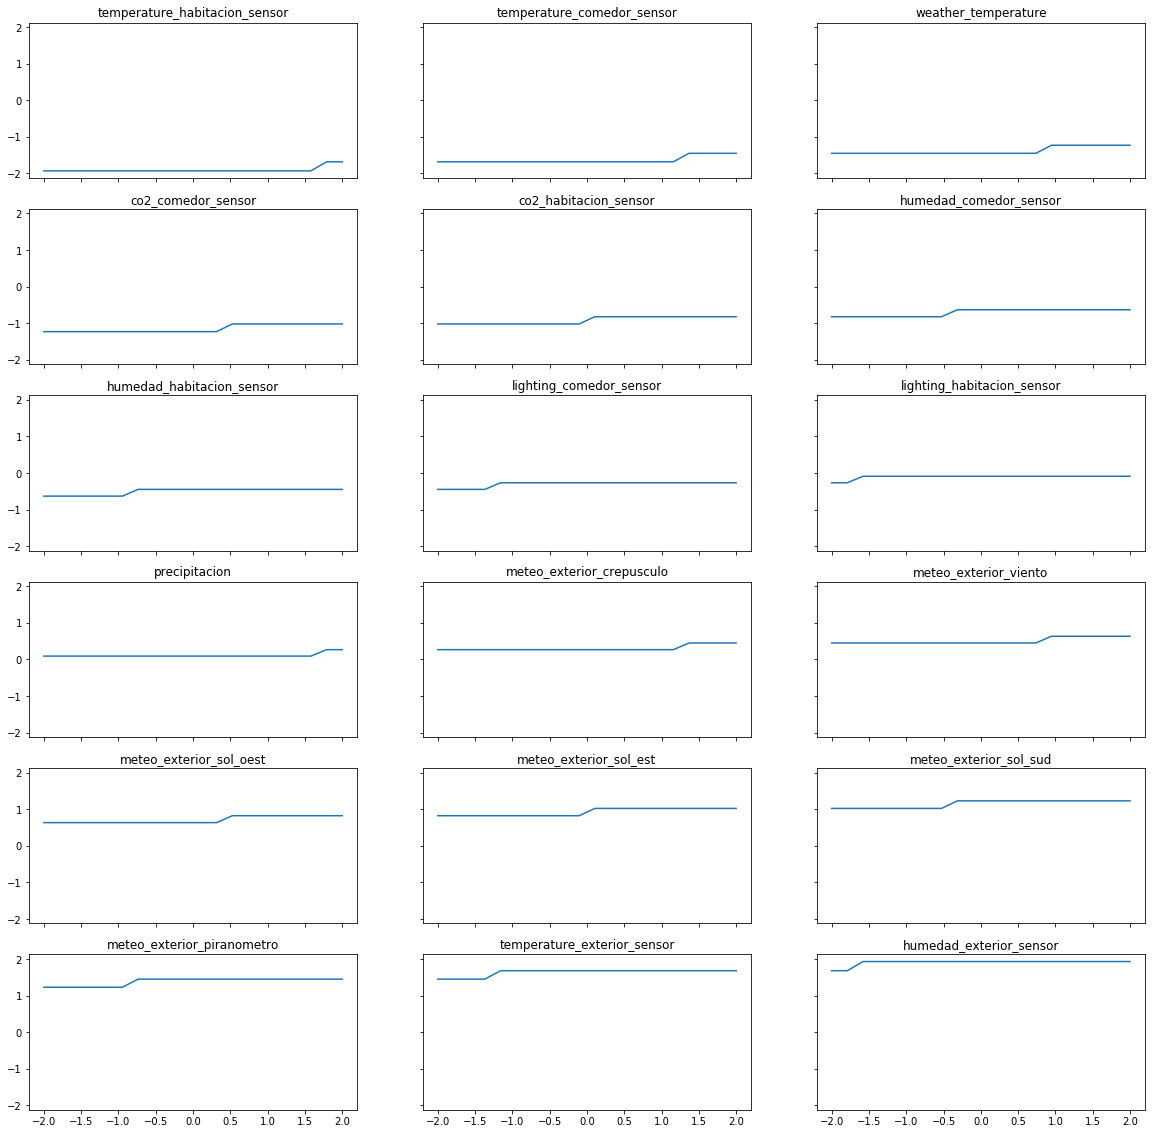

In [50]:
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)
for k,a in zip(range(18), ax.flatten()):
    a.plot(np.linspace(-2, 2,20),alpha[:, k])
    a.set_title(features[k])

In [69]:
x_tilde = attn.apply(h[:, t,:], state)

In [70]:
feed_dict = trainer._get_dict(feeds)

### First timestep, first batch of random day

In [66]:
features.pop(0)

'temperature_habitacion_sensor'

In [74]:
attn._act.alpha = tf.trainable_variables()[0]

In [79]:
x_tilde = trainer.sess.run(x_tilde, feed_dict)

In [80]:
x_tilde = x_tilde.mean(axis=0).reshape((1,-1))

In [81]:
# features importance for each a single sequence at time 0
df = pd.DataFrame(x_tilde, columns=features)

In [82]:
mif = df[df>0].fillna(0)
mif.mean(axis=0).sort_values(ascending=False)

temperature_exterior_sensor    4.095282e-05
meteo_exterior_piranometro     1.776434e-06
meteo_exterior_sol_sud         3.352081e-08
meteo_exterior_sol_oest        3.284517e-12
meteo_exterior_viento          3.119937e-14
meteo_exterior_crepusculo      1.524103e-15
lighting_habitacion_sensor     4.371796e-19
lighting_comedor_sensor        1.329603e-20
co2_habitacion_sensor          6.558442e-27
co2_comedor_sensor             8.838970e-29
day_of_week                    0.000000e+00
humedad_comedor_sensor         0.000000e+00
weather_temperature            0.000000e+00
precipitacion                  0.000000e+00
humedad_habitacion_sensor      0.000000e+00
humedad_exterior_sensor        0.000000e+00
meteo_exterior_sol_est         0.000000e+00
temperature_comedor_sensor     0.000000e+00
dtype: float32

In [83]:
lif = df[df<0.0].fillna(0)
lif.mean(axis=0).sort_values(ascending=True)

day_of_week                   -9.799737e-01
humedad_exterior_sensor       -3.613331e-03
meteo_exterior_sol_est        -1.938089e-11
precipitacion                 -2.566128e-18
humedad_habitacion_sensor     -2.155997e-23
humedad_comedor_sensor        -4.785813e-25
weather_temperature           -9.982146e-30
temperature_comedor_sensor    -2.547097e-33
lighting_comedor_sensor        0.000000e+00
lighting_habitacion_sensor     0.000000e+00
co2_comedor_sensor             0.000000e+00
meteo_exterior_crepusculo      0.000000e+00
meteo_exterior_viento          0.000000e+00
meteo_exterior_sol_oest        0.000000e+00
meteo_exterior_sol_sud         0.000000e+00
meteo_exterior_piranometro     0.000000e+00
temperature_exterior_sensor    0.000000e+00
co2_habitacion_sensor          0.000000e+00
dtype: float32

### Single batch over time steps

In [84]:
cell = tf.contrib.rnn.GRUBlockCellV2(num_units=config.encoder, reuse=tf.AUTO_REUSE, name='rnn/encoder/gru_cell')

In [85]:
from utils.tf_utils import kaf

In [186]:
states = []
c_xs = []
state = tf.zeros(shape=(8, config.encoder), dtype=tf.float32)
weights = []
for t in range(config.seq_len):
    c_x = attn.apply(h[:, t, :], state)
    w = c_x/h[:,t,:]
    weights.append(w)
    _, state = cell(c_x, state)
    states.append(state)
    c_xs.append(c_x)

In [187]:
c_xs = trainer.sess.run(c_xs, feed_dict)

In [188]:
D =  np.linspace(-1.,1., 20).reshape((-1,1))
gamma = .5 / np.square(2* (D[-1] - D[0]))
K = np.exp(-gamma * (D - D.T)**2)
init_alpha = np.linalg.solve(K + 1e-1*np.eye(20), D)

In [189]:
init_alpha = np.tile(init_alpha.reshape(-1,20), (alpha.shape[0],1))

In [190]:
def kaf_np(x, d, gamma):
    kaf = np.exp(-gamma * np.square(x - d))
    return kaf

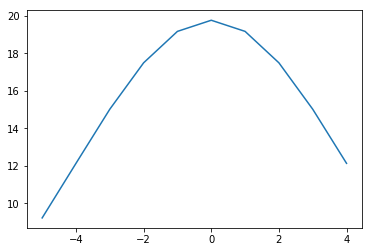

In [191]:
plt.plot(np.arange(-5,5,1), kaf_np(np.arange(-5,5, 1).reshape(1,10, 1), D.reshape((1,1, -1)), gamma).sum(axis=-1).flatten())

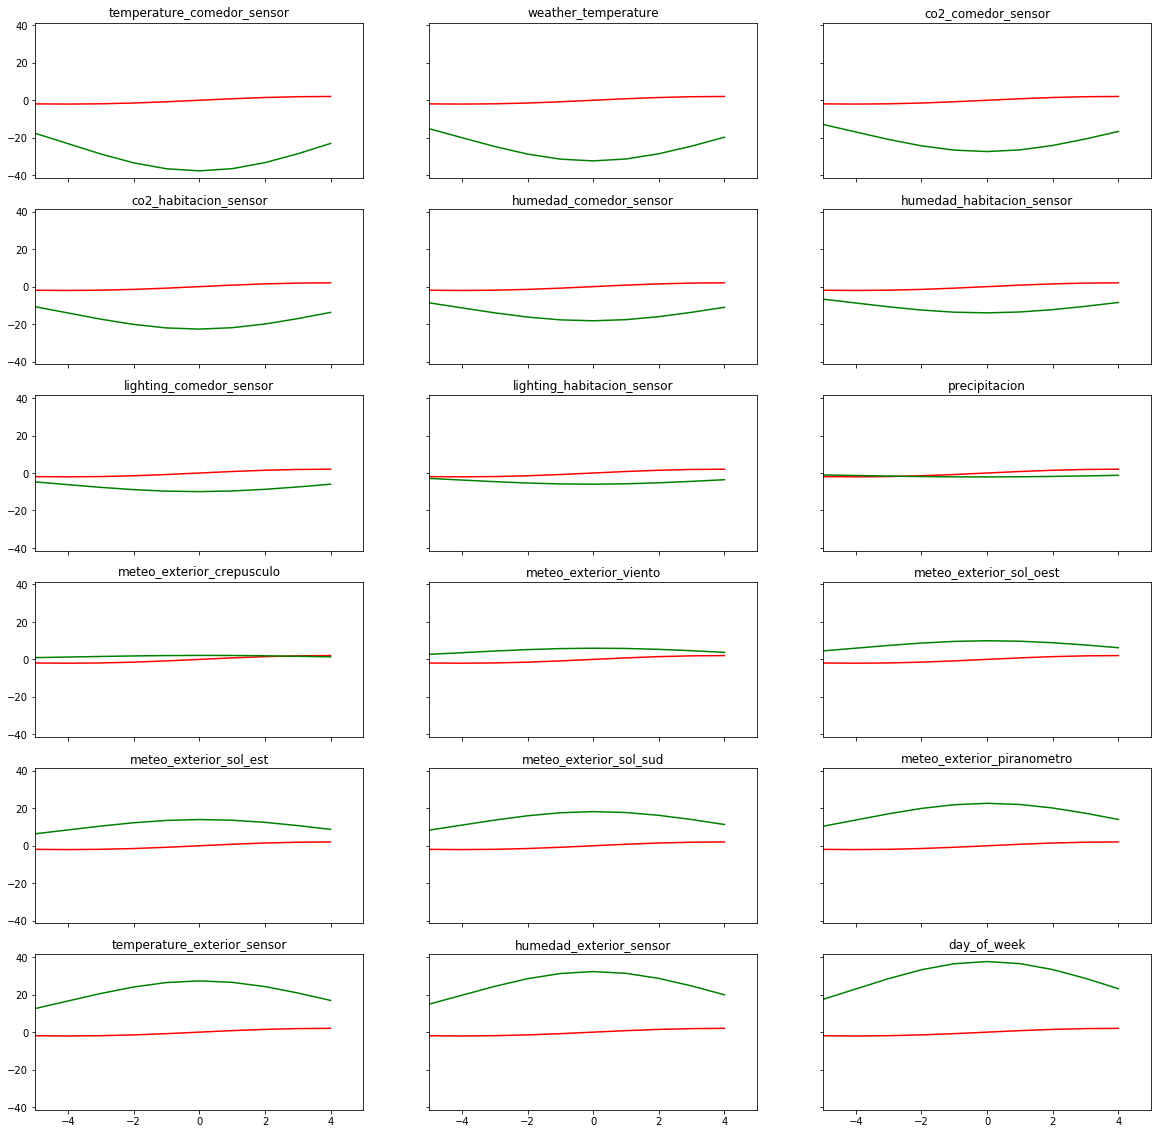

In [274]:
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)
# red init values and green trained values
k = kaf_np(np.arange(-5,5,1).reshape(1,10,1), D.reshape(1,1,-1), gamma)
for idx,a in zip(range(alpha.shape[0]), ax.flatten()):
    out_0 = (k * init_alpha[np.newaxis, idx, :]).sum(axis=-1).flatten()
    out = (k * alpha[np.newaxis,idx,:]).sum(axis=-1).flatten()
    a.plot(np.arange(-5,5,1),out_0, 'r')
    a.plot(np.arange(-5,5,1),out, '-g')
    a.set_xlim(left=-5, right=5)
    a.set_title(features[idx])

In [275]:
fig.savefig('alpha_kaf.png')

In [199]:
ws = sess.run(weights,feed_dict)

In [200]:
ws = np.array(ws)

In [193]:
c_xs=np.array(c_xs)

In [219]:
avg_ws = ws.mean(axis=1)

In [234]:
import seaborn as sns

Text(0.5, 1.0, 'Cumulative dist of activation')

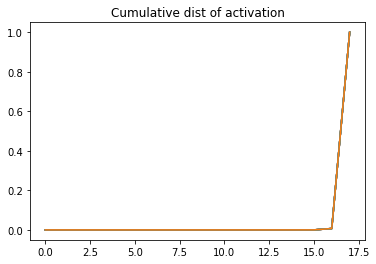

In [253]:
plt.plot(avg_ws.cumsum(axis=1).T)
plt.title('Cumulative dist of activation')

In [265]:
avg_ws[0,:]

array([6.63712322e-33, 5.31078380e-30, 1.73669818e-28, 1.99767977e-26,
       1.35189164e-24, 7.45152394e-23, 6.50956286e-21, 2.63181083e-19,
       1.23699939e-17, 1.61122935e-15, 6.82844149e-14, 6.05676056e-12,
       1.20008364e-10, 1.31120910e-08, 1.06295192e-06, 1.19854216e-04,
       7.16787390e-03, 9.92711186e-01], dtype=float32)

ValueError: x and y must have same first dimension, but have shapes (18,) and (12, 18)

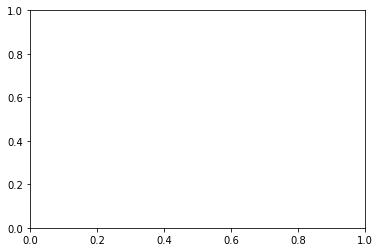

/Users/d3sm0/.virtualenvs/ntsa/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


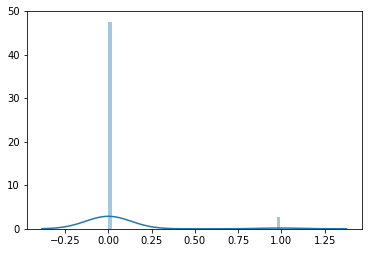

In [238]:
sns.distplot(avg_ws[0,:].flatten())a

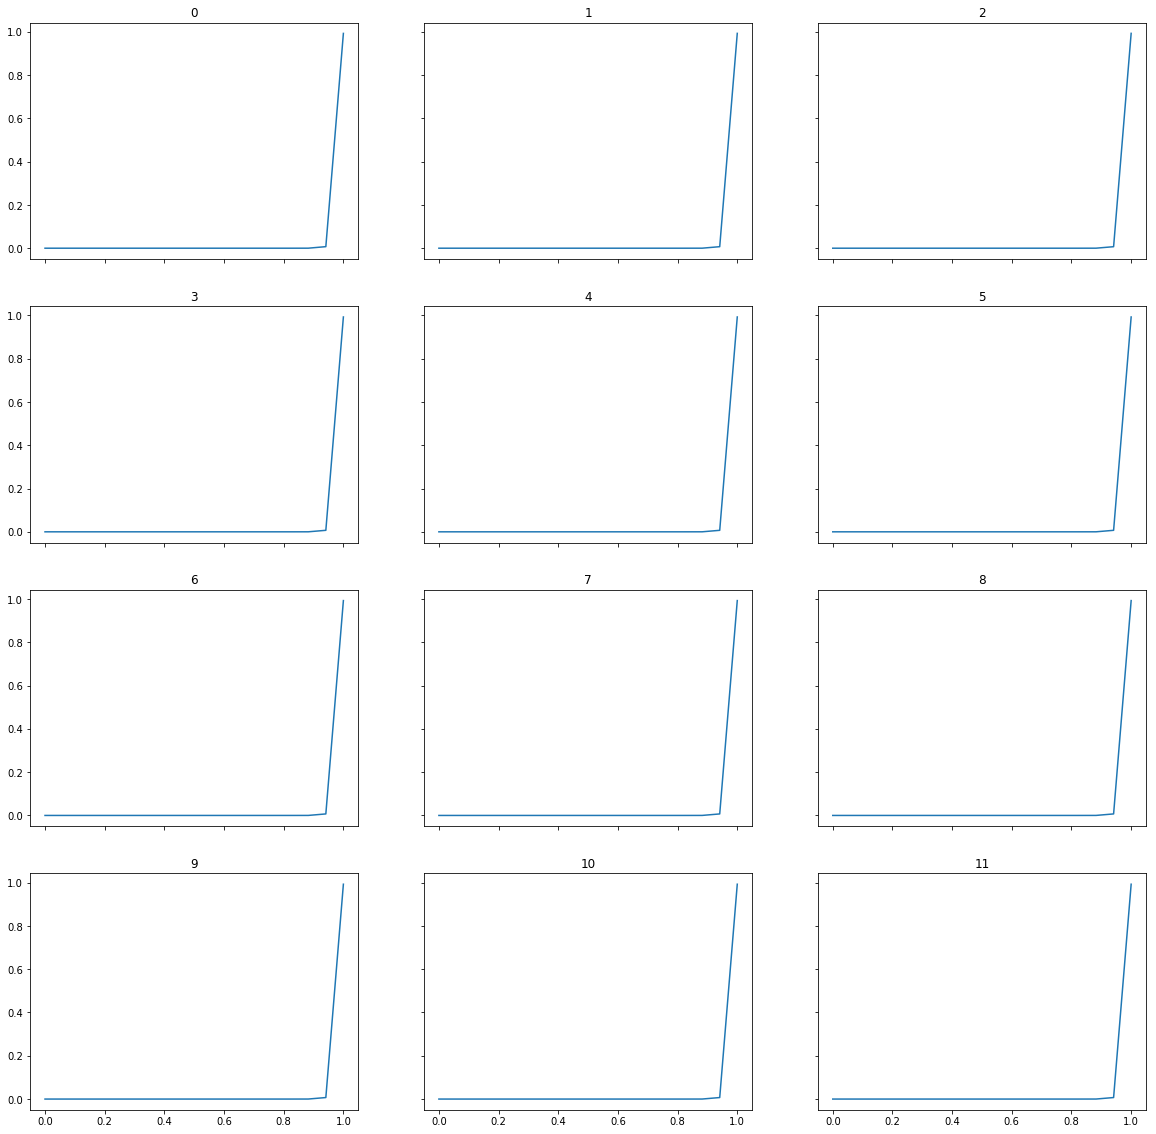

In [273]:
fig, ax = plt.subplots(4,3, figsize=(20,20), sharex=True, sharey=True)

for t,a in zip(range(avg_ws.shape[0]), ax.flatten()):
    a.plot(np.linspace(0,1,18),avg_ws[t, :])
    #a.plot(avg_ws[t,:].cumsum())
    #a.hist(avg_ws_no_kaf[t,: ], density=True)
    a.set_title(str(t))

In [ ]:
fig.savefig('ws_per_time.png')

In [ ]:
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)

for idx,a in zip(range(avg_ws.shape[-1]), ax.flatten()):
    a.plot(avg_ws[:, idx])
    a.plot(avg_ws_no_kaf[:, idx])
    a.set_title(features[idx])


In [ ]:
fig.savefig('avg_ws.png')

In [170]:
avg_c = c_xs.mean(axis=1)

In [179]:
avg_c = (avg_c - avg_c.mean(axis=0))/ (avg_c.std(axis=0) + 1e-5)

In [161]:
x_true = feed_dict[model.x]

In [162]:
avg_c_true = x_true.mean(axis=0)

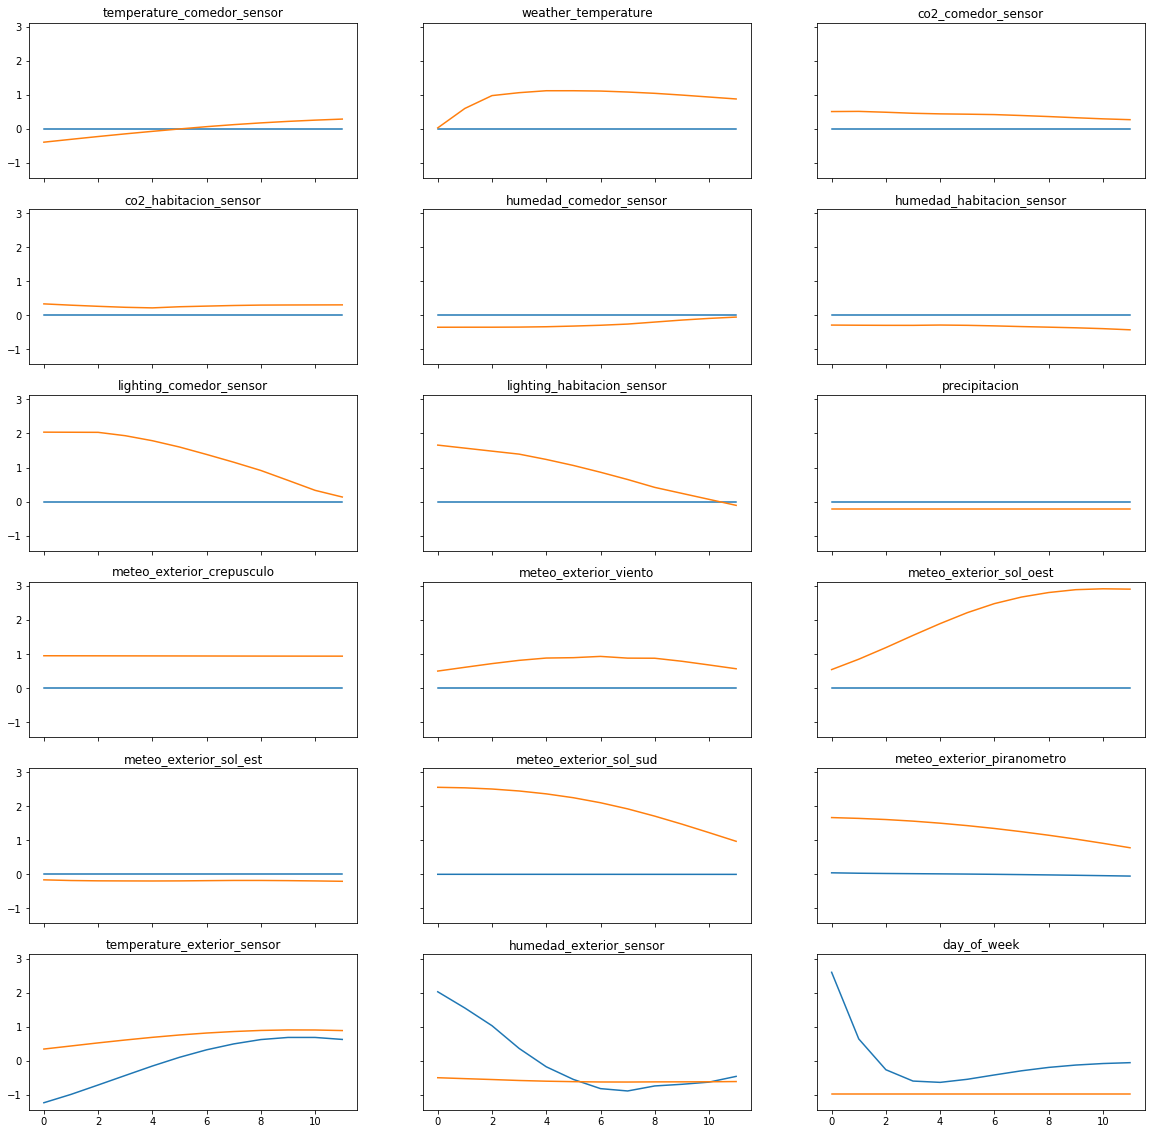

In [182]:
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)

for idx,a in zip(range(avg_c.shape[-1]), ax.flatten()):
    a.plot(avg_c[:, idx])
    a.plot(avg_c_true[:, idx])
    a.set_title(features[idx])


In [ ]:
fig.savefig('input_attn_avg_batch_kaf.png')

In [ ]:
avg_b = c_xs.mean(axis=0)

In [ ]:
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)

for idx,a in zip(range(avg_b.shape[-1]), ax.flatten()):
    a.plot(avg_b[:, idx])
    a.set_title(features[idx])


In [ ]:
fig.savefig('input_attn_avg_time')

In [ ]:
full_series = c_xs.reshape((-1,len(features)))

In [ ]:
t = (full_series - full_series.mean(axis=0)) / full_series.std(axis=0)

In [ ]:
full_series_true = x_true.reshape((-1,len(features)))

In [ ]:
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex=True, sharey=True)

for idx,a in zip(range(full_series.shape[-1]), ax.flatten()):
    a.plot(t[:, idx])
    a.plot(full_series_true[:, idx])
    a.set_title(features[idx])

In [ ]:
fig.savefig('input_attn_full.png')

In [294]:
df_= pd.read_csv('../tf/rnn/woc-2018-09-25-20-16-52/report_train.csv', index_col=0)

In [279]:
df  = pd.read_csv(path + '/report_train.csv', index_col=0)

In [ ]:
df  = pd.read_csv(path + '/report_train.csv', index_col=0)

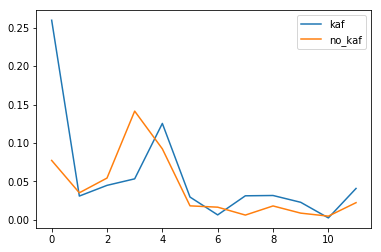

In [295]:
df.smape.plot()
df_.smape.plot()
plt.legend(['kaf', 'no_kaf'])
plt.savefig('loss.png')

In [285]:
path

'../tf/rnn/woc-2018-09-26-10-34-04'